צפייה ב-5 השורות הראשונות:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2



סטטיסטיקות בסיסיות:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000



פיזור בין משתנים:


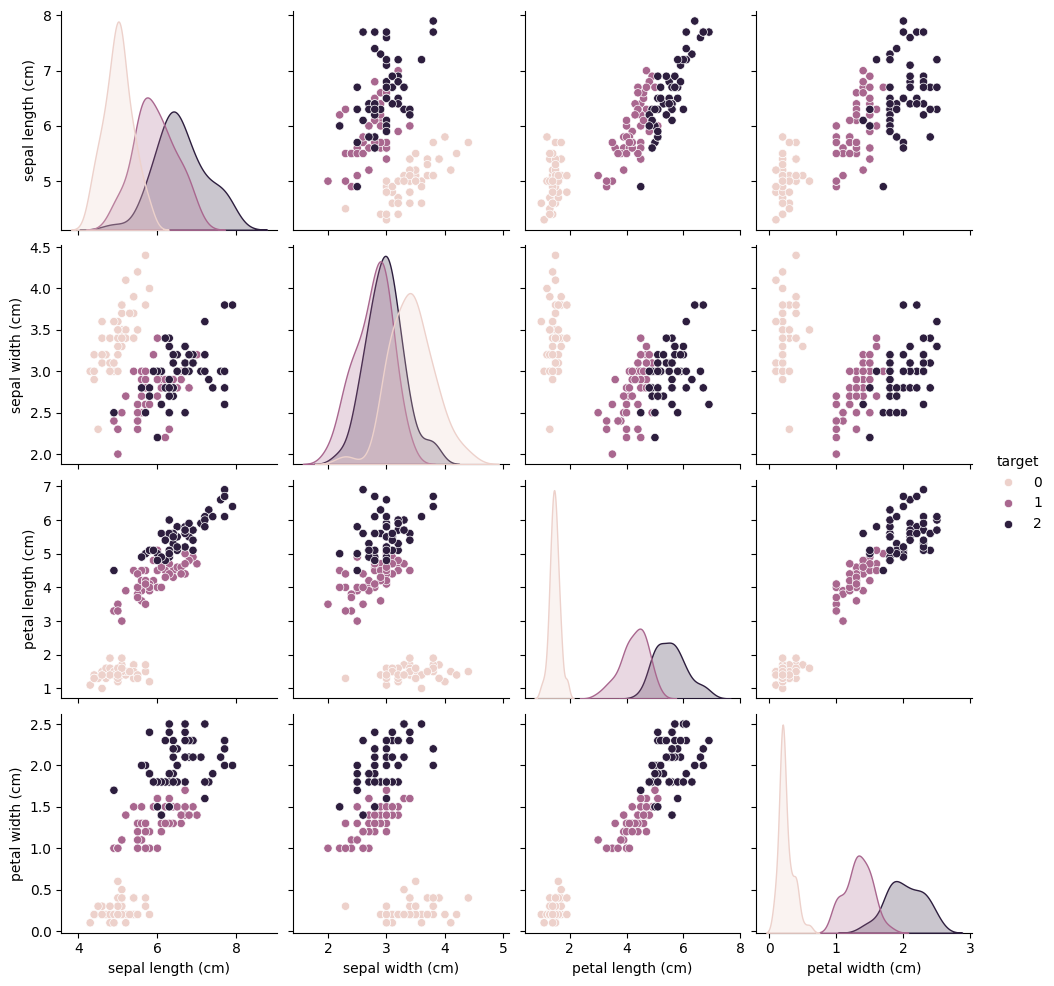

Epoch 10/50 - Loss: 0.0911, Accuracy: 0.9833
Epoch 20/50 - Loss: 0.0485, Accuracy: 0.9750
Epoch 30/50 - Loss: 0.0345, Accuracy: 0.9833
Epoch 40/50 - Loss: 0.0248, Accuracy: 0.9833
Epoch 50/50 - Loss: 0.0343, Accuracy: 0.9833


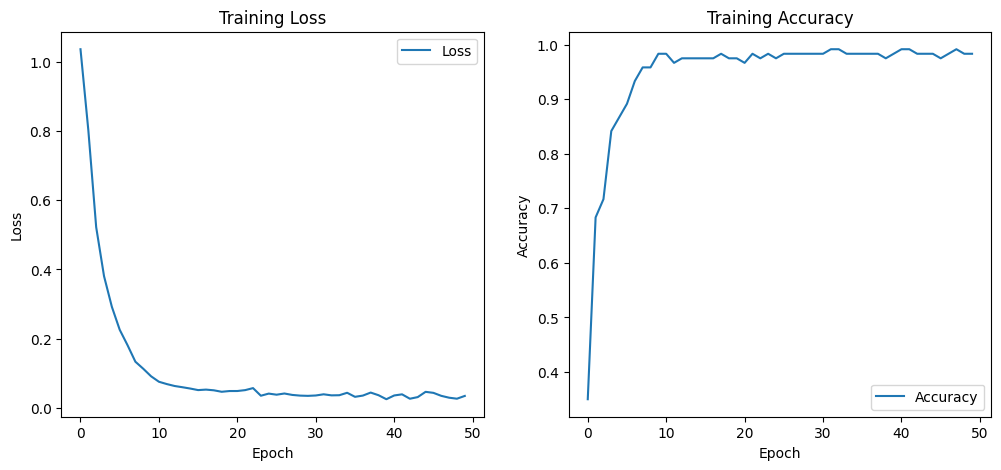


Accuracy on Test Set: 0.9666666666666667

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



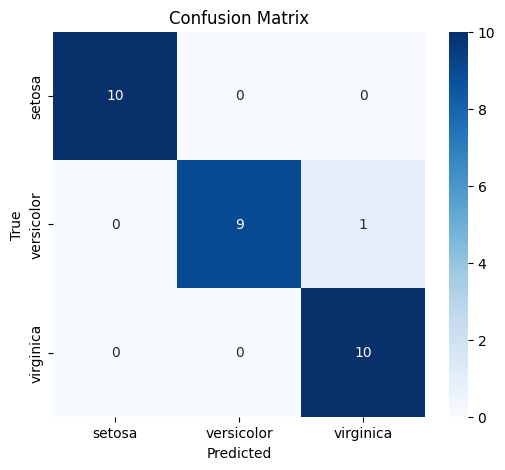

In [1]:
# Jupyter Notebook: Deep Learning Utilities

# =============================
# IMPORTS
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# =============================
# LOAD DATA
# =============================
from sklearn.datasets import load_iris
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)

# =============================
# DATA EXPLORATION
# =============================
print("צפייה ב-5 השורות הראשונות:")
display(X.head())

print("\nסטטיסטיקות בסיסיות:")
display(X.describe())

print("\nפיזור בין משתנים:")
sns.pairplot(pd.concat([X, y.rename("target")], axis=1), hue="target")
plt.show()

# =============================
# DATA PREPROCESSING
# =============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)
y_test_t = torch.tensor(y_test.values, dtype=torch.long)

# =============================
# CUSTOM DATASET
# =============================
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TabularDataset(X_train_t, y_train_t)
test_dataset = TabularDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# =============================
# DEFINE MODEL
# =============================
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

model = SimpleNN(input_dim=X.shape[1], hidden_dim=16, output_dim=len(np.unique(y)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# =============================
# TRAIN MODEL
# =============================
epochs = 50
history = {"loss": [], "accuracy": []}

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * xb.size(0)
        _, predicted = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    history["loss"].append(epoch_loss)
    history["accuracy"].append(epoch_acc)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# =============================
# PLOT TRAINING HISTORY
# =============================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["loss"], label="Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["accuracy"], label="Accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# =============================
# EVALUATE MODEL
# =============================
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(yb.tolist())

print("\nAccuracy on Test Set:", accuracy_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=iris.target_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=iris.target_names, yticklabels=iris.target_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

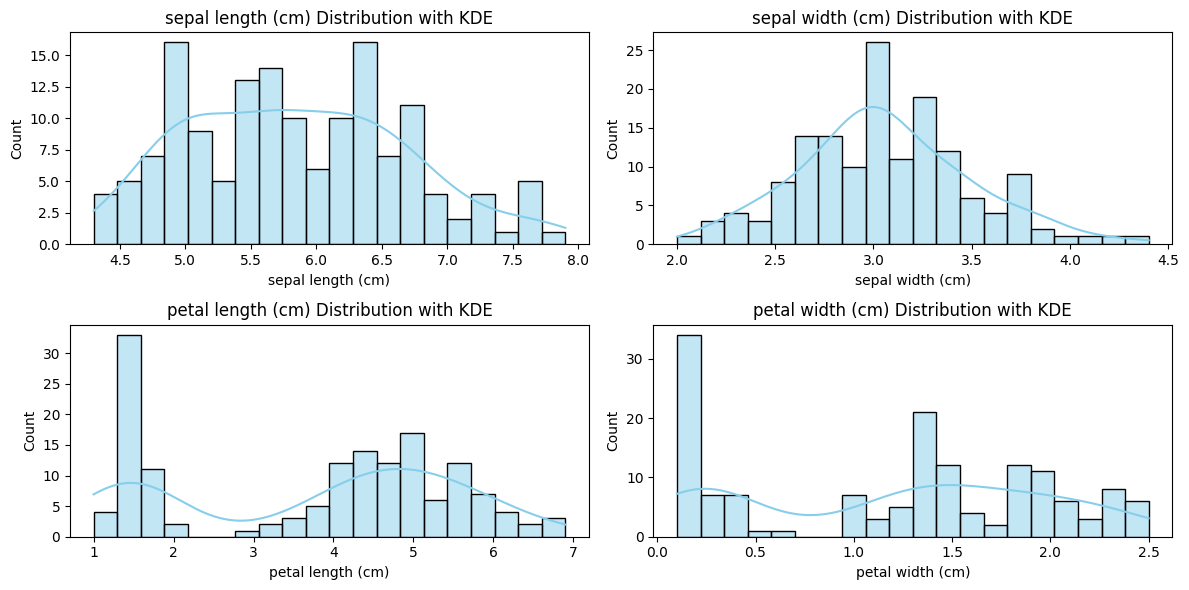

In [2]:
plt.figure(figsize=(12,6))
for i, col in enumerate(X.columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(X[col], kde=True, bins=20, color='skyblue')
    plt.title(f'{col} Distribution with KDE')
plt.tight_layout()
plt.show()


/var/folders/c8/68n9_s8d6sxg8pl5bmt94v180000gn/T/ipykernel_13141/1532860017.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=X[col], palette="Pastel1")
/var/folders/c8/68n9_s8d6sxg8pl5bmt94v180000gn/T/ipykernel_13141/1532860017.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=X[col], palette="Pastel1")
/var/folders/c8/68n9_s8d6sxg8pl5bmt94v180000gn/T/ipykernel_13141/1532860017.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=X[col], palette="Pastel1")
/var/folders/c8/68n9_s8d6sxg8pl5bmt94v180000gn/T/ipykernel_13

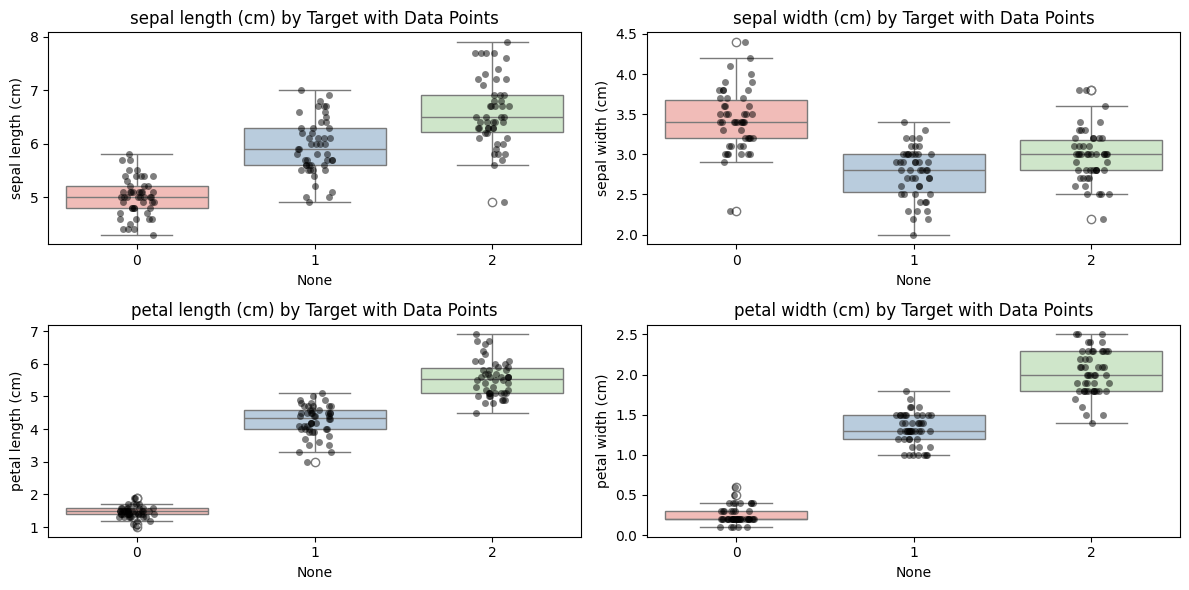

In [3]:
plt.figure(figsize=(12,6))
for i, col in enumerate(X.columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=y, y=X[col], palette="Pastel1")
    sns.stripplot(x=y, y=X[col], color='black', alpha=0.5)
    plt.title(f'{col} by Target with Data Points')
plt.tight_layout()
plt.show()


/var/folders/c8/68n9_s8d6sxg8pl5bmt94v180000gn/T/ipykernel_13141/3506921759.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=y, y=X[col], palette="muted", inner='quartile')
/var/folders/c8/68n9_s8d6sxg8pl5bmt94v180000gn/T/ipykernel_13141/3506921759.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=y, y=X[col], palette="muted", inner='quartile')
/var/folders/c8/68n9_s8d6sxg8pl5bmt94v180000gn/T/ipykernel_13141/3506921759.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=y, y=X[col], palette="muted", inner='quartile')
/var

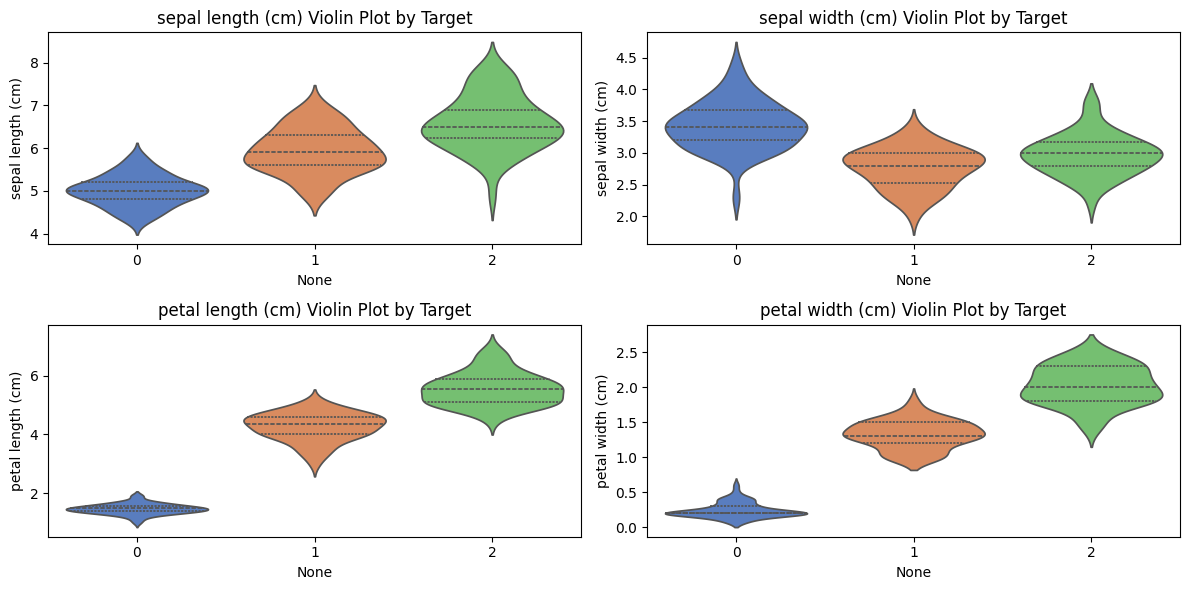

In [4]:
plt.figure(figsize=(12,6))
for i, col in enumerate(X.columns, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(x=y, y=X[col], palette="muted", inner='quartile')
    plt.title(f'{col} Violin Plot by Target')
plt.tight_layout()
plt.show()


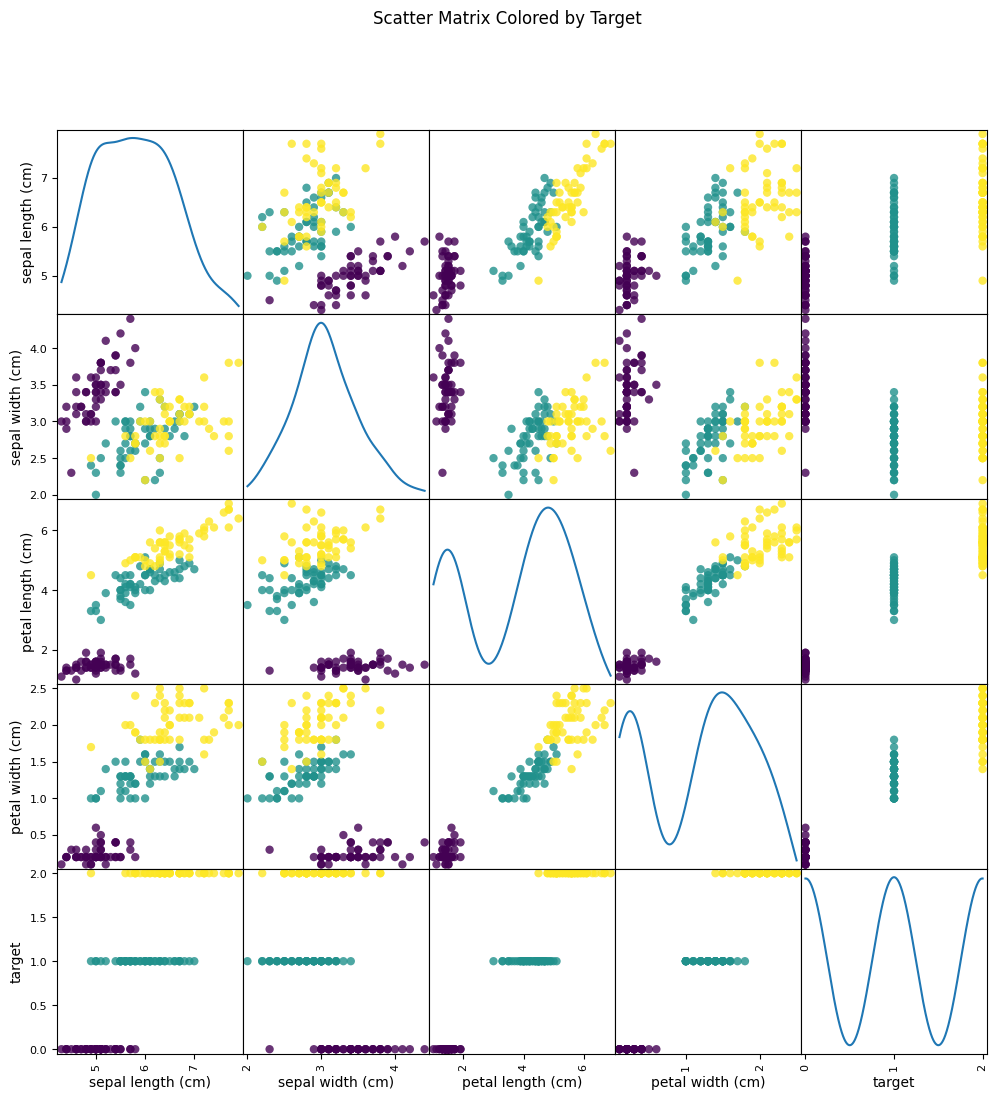

In [5]:
from pandas.plotting import scatter_matrix

scatter_matrix(pd.concat([X, y.rename("target")], axis=1), figsize=(12,12), diagonal='kde', c=y, marker='o', alpha=0.8)
plt.suptitle("Scatter Matrix Colored by Target")
plt.show()


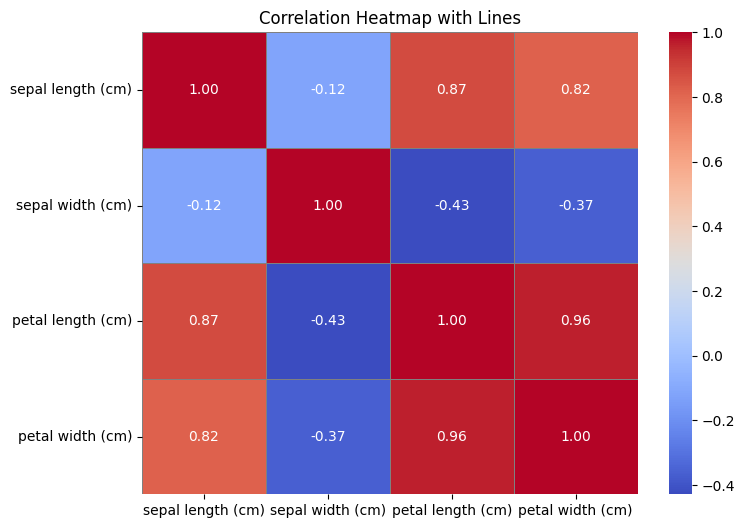

In [6]:
plt.figure(figsize=(8,6))
corr = X.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, linecolor='gray', cbar=True)
plt.title("Correlation Heatmap with Lines")
plt.show()


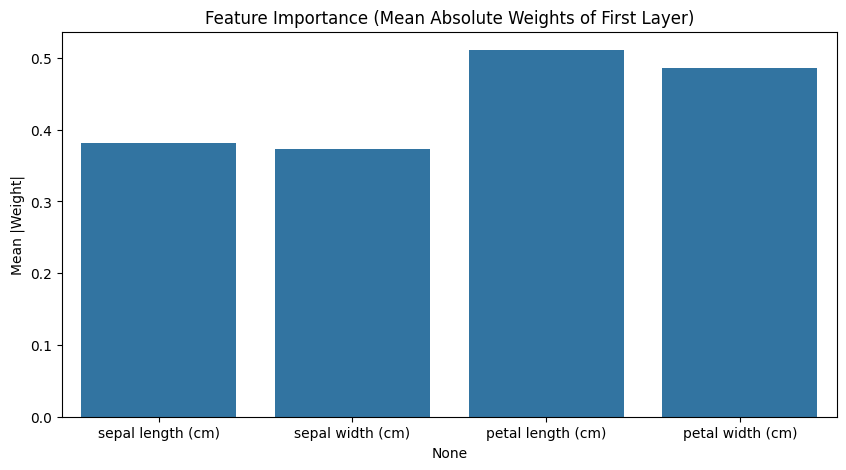

In [7]:
weights = model.net[0].weight.detach().numpy()
plt.figure(figsize=(10,5))
sns.barplot(x=X.columns, y=np.mean(np.abs(weights), axis=0))
plt.title("Feature Importance (Mean Absolute Weights of First Layer)")
plt.ylabel("Mean |Weight|")
plt.show()


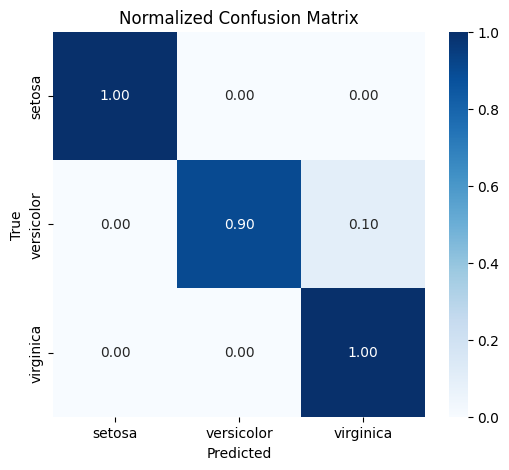

In [8]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", xticklabels=iris.target_names, yticklabels=iris.target_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()


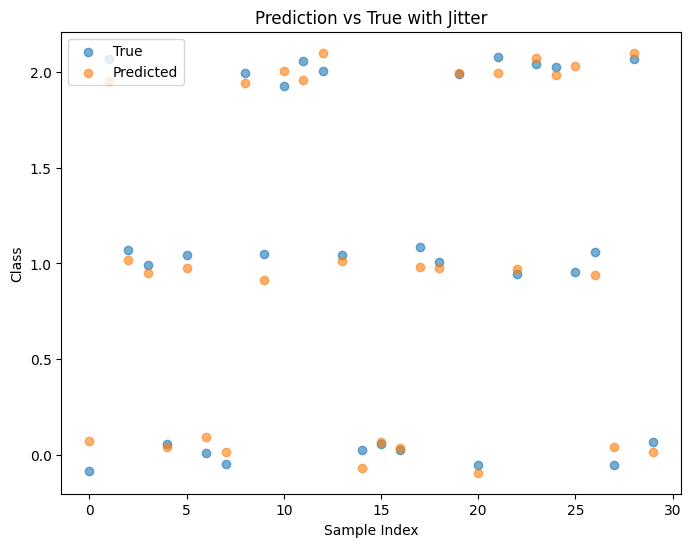

In [9]:
plt.figure(figsize=(8,6))
y_true_jitter = y_true + np.random.uniform(-0.1, 0.1, size=len(y_true))
y_pred_jitter = y_pred + np.random.uniform(-0.1, 0.1, size=len(y_pred))
plt.scatter(range(len(y_true)), y_true_jitter, label='True', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred_jitter, label='Predicted', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.title('Prediction vs True with Jitter')
plt.legend()
plt.show()
